# Coming from TensorFlow to NengoDL

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/from-tensorflow.ipynb)

NengoDL combines two frameworks: Nengo and TensorFlow.  This tutorial is designed for
people who are familiar with TensorFlow and looking to learn more about neuromorphic
modelling with NengoDL.  For the other approach, users familiar with Nengo looking to
learn how to use NengoDL, check out [this
tutorial](https://www.nengo.ai/nengo-dl/examples/from-nengo.html).

If you are familiar with Keras you may also be interested in
[KerasSpiking](https://www.nengo.ai/keras-spiking/), a companion project to NengoDL
that has a more minimal feature set, but integrates even more transparently with the
Keras API. See [this page](https://www.nengo.ai/keras-spiking/nengo-dl-comparison.html)
for a more detailed comparison between the two projects.

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import nengo
from nengo.utils.matplotlib import rasterplot
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import binary_crossentropy

import nengo_dl


warnings.simplefilter("ignore")
tf.get_logger().addFilter(lambda rec: "Tracing is expensive" not in rec.msg)

In [38]:
from tensorflow.keras.datasets import mnist

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)


## What is Nengo

We'll start with the very basics, where you might be wondering what Nengo is and why you
would want to use it.  Nengo is a tool for constructing and simulating neural networks.
That is, to some extent, the same purpose as TensorFlow (and its higher level API,
Keras).  For example, here is how we might build a simple two layer auto-encoder network
in Nengo:

In [39]:
n_in = 784
n_hidden = 20
minibatch_size = 60

In [40]:
# Construct the network
with nengo.Network() as model:
    # set up some default parameters to match the Keras defaults
    model.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    model.config[nengo.Ensemble].bias = nengo.dists.Choice([0.001])
    model.config[nengo.Connection].synapse = None
    model.config[nengo.Connection].transform = nengo_dl.dists.He()
    model.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    model.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    neuron_type = nengo.LIF(amplitude=0.01)
    # input
    nengo_a = nengo.Node(np.zeros(n_in))

    # encoder layer
    nengo_b = nengo.Ensemble(n_hidden, 1,radius=1)
    nengo.Connection(nengo_a, nengo_b.neurons)
    
    nengo_c = nengo.Ensemble(n_hidden, 2,radius=1.5)
    nengo.Connection(nengo_b.neurons, nengo_c[0])
    nengo.Connection(nengo_b.neurons, nengo_c[1])
    def reparameterize(x):
        eps=0*tf.random.normal(shape=[1])
        return x[0] + eps*tf.math.exp(0.5*float(x[1]))
    
    # decoder layer
    nengo_d = nengo.Ensemble(n_in, 1,radius=1)
    nengo.Connection(nengo_c, nengo_d.neurons, function=reparameterize)
    
    # define the loss functions
    def L_KLD(x):
        # x[0]: mean, mu, c[0]
        # x[1]: logvar, sigma, c[1]
#         print("L_KLD.shape: ")
#         print(x.shape)
        return 0
        return -0.5*(1+x[1]-x[0]**2-tf.math.exp(float(x[1])))
    def L_MSE(x):
        # x[0]: original data, e[0]
        # x[1]: reconstructed, e[1]
#         print("L_MSE.shape: ")
# #         print(x.shape)
#         print("MSE:")
#         print(x[0])
#         print(x[1])
#         print(n_in*(x[0]-x[1])**2)
        return n_in*(x[0]-x[1])**2
    def L_TOTAL(x):
        # x[0]: L_KLD, L[0]
        # x[1]: L_MSE, L[1]
#         print("L_TOTAL.shape: ")
#         print(x.shape)
        print("L_KLD:")
        print(x[0])
        print("L_MSE:")
        print(x[1])
        return x[0]+x[1]+1e-8
    
    nengo_e = nengo.Ensemble(n_in,2,radius=1.5)
    nengo.Connection(nengo_a,nengo_e[0])
    nengo.Connection(nengo_d,nengo_e[1])
    
    nengo_l = nengo.Ensemble(1,2,radius=1.5)
    nengo.Connection(nengo_c,nengo_l[0],function=L_KLD)
    nengo.Connection(nengo_e,nengo_l[1],function=L_MSE)
    
    nengo_loss = nengo.Ensemble(1,1,radius=1)
    nengo.Connection(nengo_l,nengo_loss,function=L_TOTAL)
    
    # probes are used to collect data from the network
    #p_l = nengo.Probe(nengo_loss.neurons)
    p_d = nengo.Probe(nengo_d.neurons)
    
    
#     p_c = nengo.Probe(nengo_c.neurons)
#     p_b = nengo.Probe(nengo_b.neurons)
#     p_a = nengo.Probe(nengo_a)
    
#     print("nengo_a.params: ")
#     for p in nengo_a:
#         print(p)

#     print("nengo_b.params: ")
#     for p in nengo_b:
#         print(p)

#     print("nengo_c.params: ")
#     for p in nengo_c:
#         print(p)

#     print("nengo_d.params: ")
#     for p in nengo_d:
#         print(p)
        
#     print("p_d:")
#     print(nengo_d.probeable)
#     for p in p_d.params:
#         print(p)
#     print("p_c:")
#     print(nengo_c.probeable)
#     for p in p_c.params:
#         print(p)
#     print("p_b:")
#     print(nengo_b.probeable)
#     for p in p_b.params:
#         print(p)
#     print("p_a:")
#     print(nengo_a.probeable)
#     for p in p_a.params:
#         print(p)

L_KLD:
0.0
L_MSE:
0.0


In [41]:
# Define the comibned loss function
def spiking_loss(y_true, y_pred):
    # Compute reconstruction loss using spike-timing-dependent plasticity (STDP)
    reconstruction_loss = tf.losses.mse(y_true, y_pred)
    
    # Return the sum of reconstruction loss
    #return tf.reduce_sum(y_pred)/y_pred.shape[0]
    return reconstruction_loss

# download MNIST dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
# flatten images
train_data = train_data.reshape((train_data.shape[0], -1)).astype('float32')/255.0
test_data = test_data.reshape((test_data.shape[0], -1)).astype('float32')/255.0

n_epochs = 1

train_data = train_data[:, None, :]
test_data = test_data[:, None, :]

print(test_data.shape)
# Simulate the Nengo network
with nengo_dl.Simulator(model,minibatch_size=minibatch_size) as sim:
    # compile the network
    sim.compile(optimizer=tf.optimizers.Adam(1e-3), loss=spiking_loss)

    # run training loop
    sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    sim.evaluate(test_data, test_data)
    
    #sim.freeze_params(model)
    
    # Display the example output
    plt.figure()
    plt.imshow(test_data[0,0,:].reshape((28,28)))
    plt.show()
    print(minibatch_size)
    print(test_data[:minibatch_size].shape)
    output = sim.predict(test_data[:minibatch_size])
    #print(output)
    plt.figure()
    plt.imshow(output[p_d][0].reshape((28,28)))
    plt.show()

(10000, 1, 784)
|#####################Building network (55%)                     | ETA: 0:00:07


BuildError: Building <Connection from <Ensemble (unlabeled) at 0x2cefc2c7ac8> to <Neurons of <Ensemble (unlabeled) at 0x2cebc36cac8>> computing 'reparameterize'>: 'activities' matrix is all zero for <Ensemble (unlabeled) at 0x2cefc2c7ac8>. This is because no evaluation points fall in the firing ranges of any neurons.

Build finished in 0:00:03                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Simulation finished in 0:00:01                                                 


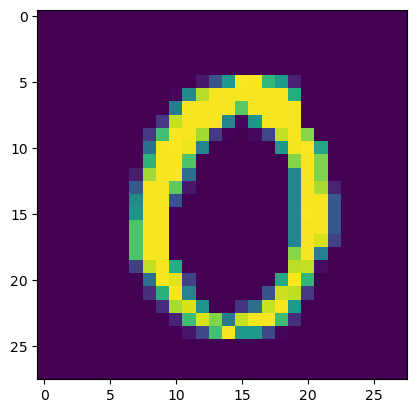

60
(60, 1, 784)
1/1 [==============================] - 1s 662ms/step                         


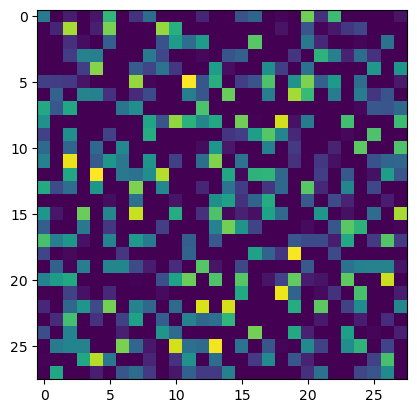

Text(0.5, 1.0, 'output')

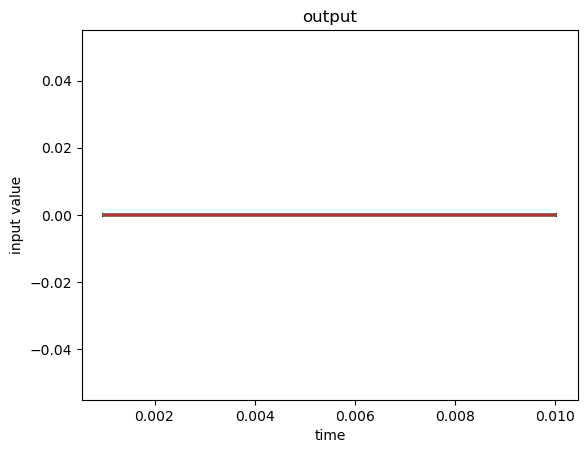

In [193]:
with nengo_dl.Simulator(model,minibatch_size=minibatch_size) as sim:
    ind = tf.random.uniform(shape=(), minval=0, maxval=minibatch_size, dtype=tf.int32)
    sim.run_steps(10)
    # Display the example output
    plt.figure()
    plt.imshow(test_data[ind,0,:].reshape((28,28)))
    plt.show()
    print(minibatch_size)
    print(test_data[:minibatch_size].shape)
    output = sim.predict(test_data[:minibatch_size])
    #print(output)
    plt.figure()
    plt.imshow(output[p_d][ind].reshape((28,28)))
    plt.show()

plt.figure()
plt.plot(sim.trange(), sim.data[p_d][0])
plt.xlabel("time")
plt.ylabel("input value")
plt.title("output")

One difference you'll note is that with Nengo we separate the creation of the layers and
the creation of the connections between layers.  This is because the connection
structure in Nengo networks often has a lot more state and general complexity than in
typical deep learning networks, so it is helpful to be able to control it independently
(we'll see examples of this later).

Another new object you may notice is the `nengo.Probe`.  This is used to collect data
from the simulation; by adding a probe to `nengo_c.neurons`, we are indicating that we
want to collect the activities of those neurons when the simulation is running.  You can
think of this like the `outputs` arguments in a Keras Model.

We will not go into a lot of detail on Nengo here; there is much more functionality
available, but we will focus on the features most familiar or relevant to those coming
from a TensorFlow background.  For a more in-depth introduction to Nengo, check out the
Nengo-specific [documentation](https://www.nengo.ai/nengo/) and
[examples](https://www.nengo.ai/nengo/examples.html).

## Inserting TensorFlow code

The goal of NengoDL is not to replace TensorFlow or Nengo, but to allow them to smoothly
work together.  Thus one important feature is the ability to write TensorFlow code
directly, and insert it into a Nengo network.  This allows us to use whichever framework
is best suited for different parts of a model.

This functionality is accessed through the `nengo_dl.TensorNode` class.  This allows us
to wrap TensorFlow code in a Nengo object, so that it can easily communicate with the
rest of a Nengo model.  The TensorFlow code is written in a function that takes
`tf.Tensors` as input, applies the desired manipulations through TensorFlow operations,
and returns a `tf.Tensor`.  We then pass that function to the TensorNode.

For simple cases we can use `nengo_dl.Layer`.  This is a simplified interface for
constructing `TensorNodes` that mimics the Keras functional API.  For example, suppose
we want to apply batch normalization to the output of one of the Nengo ensembles.  There
is no built-in way to do batch normalization in Nengo, so we can instead turn to
TensorFlow for this part of the model.

In [ ]:
with nengo.Network() as vae_net:
    # input
    vae_a = nengo.Node(np.zeros(n_in,1))

    # encoder layer
    nengo_b = nengo.Ensemble(n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(nengo_a, nengo_b.neurons, transform=nengo_dl.dists.He())
    
    
    
    
    
    # decoder layer
    nengo_c = nengo.Ensemble(n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, transform=nengo_dl.dists.He()
    )

    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

    a = nengo_dl.TensorNode(MyLayer(), shape_in=(1,), pass_time=False)

More details on TensorNode usage can be found in [the user
guide](https://www.nengo.ai/nengo-dl/tensor-node.html).

## Deep learning parameter optimization

NengoDL allows model parameters to be optimized via TensorFlow optimization algorithms,
through the `Simulator.fit` function.  Returning to the autoencoder examples from the
beginning of this tutorial, we'll optimize those networks to encode MNIST digits.

In [ ]:
# download MNIST dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
# flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))

n_epochs = 2

Before running the same training in NengoDL, we'll change the Nengo model parameters to
more closely match the TensorFlow network (we omitted these details in the original
presentation to keep things simple).

In [ ]:
# set initial neuron gains to 1 and biases to 0
for ens in auto_net.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in auto_net.all_connections:
    conn.synapse = None

We also need to modify the data slightly.  As mentioned above, NengoDL simulations are
essentially temporal, so data is described over time (indicating what the inputs/targets
should be on each simulation timestep).  So instead of the data having shape
`(batch_size, n)`, it will have shape `(batch_size, n_steps, n)`.  In this case we'll
just be training for a single timestep, but we still need to add that extra axis with
length 1.

In [ ]:
train_data = train_data[:, None, :]
test_data = test_data[:, None, :]

Now we can run the NengoDL equivalent of the above TensorFlow training (note: the
results will not match exactly due to different random initializations):

In [ ]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

    # run training loop
    sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    sim.evaluate(test_data, test_data)

    # display example output
    plt.figure()
    plt.imshow(test_data[0,0,:].reshape((28, 28)))
    plt.show()
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(output[p_c][0].reshape((28, 28)))
    plt.show()

In [ ]:
print(p_c)
print(output)

In [ ]:
with nengo.Network(seed=0) as net:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node(np.zeros(28 * 28))

    # add the first convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=32, kernel_size=3))(
        inp, shape_in=(28, 28, 1)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # add the second convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=64, strides=2, kernel_size=3))(
        x, shape_in=(26, 26, 32)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # add the third convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=128, strides=2, kernel_size=3))(
        x, shape_in=(12, 12, 64)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # linear readout
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=10))(x)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

More details on using `sim.fit` can be found in [the user
guide](https://www.nengo.ai/nengo-dl/simulator.html).

## Conclusion

In this tutorial we have demonstrated how to translate TensorFlow concepts into NengoDL,
including network construction, execution, and optimization.  We have also discussed how
to use TensorNodes to combine TensorFlow and Nengo code, and introduced some of the
unique features of Nengo (such as NEF optimization and neuromorphic cross-platform
execution).  However, there is much more functionality in NengoDL than we are able to
introduce here; check out the [user
guide](https://www.nengo.ai/nengo-dl/user-guide.html) or [other
examples](https://www.nengo.ai/nengo-dl/examples.html) for more information.  If you
would like more information on how NengoDL is implemented under the hood using
TensorFlow, check out the [white paper](https://arxiv.org/abs/1805.11144).